# PARTIE I : STATISTIQUES DESCRIPTIVES ET ETUDES DE CAS 
## A/PREMIERES TENDANCES AVEC LES STATS DESC


Le but de cette partie est d'évaluer les premières tendances que l'on pourrait remarquer. Notre objectif est de voir si on remarque facilement des spécifités géographiques dans la répartition des maladies

On importe tous les modules nécéssaires :

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import requests
!pip install --upgrade xlrd #colab bug verson xlrd
!pip install geopandas
!pip install pandas fiona shapely pyproj rtree
!pip install contextily
!pip install pygeos
!pip install topojson
import geopandas as gpd
import contextily as ctx
import matplotlib.pyplot as plt
import textwrap
#!pip install requests py7zr geopandas openpyxl tqdm s3fs PyYAML xlrd
#!pip install git+https://github.com/inseefrlab/cartiflette@80b8a5a28371feb6df31d55bcc2617948a5f9b1a

On importe nos base de travail issue de l'INSEE pour les effectifs de la population par département, de data.gouv pour les sources de pollution et les maladies. Les données sur les maladies ont été collectées par l'Assurance Maladie et celles sur la pollution par l'ADEME (Agence de l'environnement et de la maîtrise de l'énergie).

In [ ]:
#La base de données effectifs, notre base de travail principale qui nous renseigne sur les pathologies, 
#issue des données de l'Assurance maladie et provenant du site datagouv 
eff = pd.read_csv("effectifs.csv", sep = ";", encoding = 'utf-8', engine = 'python')

On réalise quelques histogrammes pour voir quelles sont les tendances qui se dessinent :

In [ ]:
#Diagramme en barres sur le nombre de cas par type de maladie

# Compter le nombre de cas par type de maladie
counts = eff['patho_niv1'].value_counts()

# Créer le diagramme en barres
plt.bar(counts.index, counts.values,  width=0.6)
plt.xlabel('Type de maladie')
plt.ylabel('Nombre de cas')
plt.title('Nombre de cas par type de maladie')

# Ajouter des lignes horizontales en arrière-plan
for y in range(0, max(counts.values) + 1, 10000):  # Ajuster l'espacement des lignes selon vos besoins
    plt.axhline(y, color='gray', linestyle='--', linewidth=0.5)

# Rotation des étiquettes en diagonale
plt.xticks(rotation=45, ha='right')

plt.show()


On remarque que parmi les pathologies de niveau 1 (le niveau le moins précis), les cancers sont avec les maladies cardio vasculaires les premières maladies dont sont atteints les individus de la base. Il est donc intéressant à cet égard de regarder ce type de maladie pour avoir des résultats significatifs par la suite.

Nous avons par ailleurs à disposition des variables descriptives liées à la pollution. En effet, à l'aide de la table IGT - Pouvoir de réchauffement global.csv nous sommes en capacité d'estimer la quantité mais également la source de pollution de chaque département comme un variable supplémentaire servant à caractériser
l'environnement (et les maladies qui peuvent en découler) des départements français.
Ces informations seront utilisées plus tard dans le code.


In [ ]:
#Dataframes sommant les niveaux de pollution par source
#selon la région :
pollution_group_reg = pd.read_csv('pollution_group_reg.csv', sep=',', encoding='utf-8')
#selon le département :
pollution_group_dep = pd.read_csv('pollution_group_dep.csv', sep=',', encoding='utf-8')

## B/ETUDES DE CAS 

### 1/PREMIERE ETUDE DE CAS : LES CANCERS DE LA PROSTATE SONT-ILS PLUS NOMBREUX EN BRETAGNE ? 

Dans cette premiere étude de cas nous chercherons à comprendre si en étudiant une varibale saillante, qui caractérise bien un département mais qui est également en lien direct avec l'apparition d'une certaine maladie, nous sommes en mesure ou non d'inférer le fait que la proportion maladie en question va être particulièrement élevé dans le département en question.

Nous avons décidé de nous pencher sur un cas qui a déjà marqué l'actualié : la polluton agricole en Bretagne. D'après la fondation pour la nature et l'homme la pollution liée à l'agriculture favoriserait un certain nombre de maladies comme les cancers de la prostate. Nous allons donc essayer de voir si dans le département 
29, le Finistère, le taux de cancer de la prostate parmi la population est plus élevé que la moyenne. 

Vérifions d'abord avec nos données qu'une forte pollution liée à l'agriculture est bien une caratéristique du Finistère :

In [ ]:
#Choisir le numéro du département dont on veut observer les sources de pollution
x = input("Entrer un numéro de département (mettre un 0 devant si c'est un chiffre) : ")

In [ ]:
# Sélectionnez les données pour le département x
pollution_dep_x = pollution_group_dep[pollution_group_dep['DEP'] == x]

# Sélectionnez les colonnes correspondant aux sources de pollution
sources_pollution = pollution_dep_x.columns[1:10]

# Créez un diagramme en barres
plt.bar(sources_pollution, pollution_dep_x.iloc[0, 1:10])
plt.xlabel('Sources de pollution')
plt.ylabel('Niveau de pollution')
plt.title('Niveau de pollution par source pour le département {}'.format(x))
plt.xticks(rotation=45, ha='right')

plt.show()


On constate donc qu'il y a bien une forte pollution liée à l'agriculture dans le Finistère, on va maintenant chercher à comparer la prévalence de cancer de la prostate dans la Finistère et dans les autres départements.

Pour se faire, nous allons recourir à une copie de notre base de données intiale que nous renommeront base_grande. Cette va être retravaillée afin de convenir à notre démarche. On va par exemple changer les classes d'âges et les transformer en un âge unique. On va aussi utiliser dummies afin de créer des variables catégorielles sur chacun de nos pathologie de niveau 2 pour pouvoir isoler plus facilement les individus atteints d'un cancer de la prostate. La prostate étant un organe masculin, il n'y aura donc plus que des individus masculins dans la population d'intérêt.

In [ ]:
#Par rapport aux autres histogramme ici on va prendre pathoniv2 pour les dummies 
base_grande = pd.read_csv("effectifs.csv", sep = ";", encoding = 'utf-8', engine = 'python')
base_grande.shape
base_grande = base_grande.dropna()
base_grande = pd.get_dummies(base_grande, prefix = 'indicatrice_', columns=['patho_niv2'], dtype='int')


liste_var = base_grande.columns[17:]
liste_bis = []
for i in liste_var : 
    liste_bis.append(i)
indicatrice_patho_niv1 = liste_bis

liste_auxil = base_grande['cla_age_5'].unique()
inter_excl = ('95et+', 'tsage', np.nan)

inter_def = []
for i in liste_auxil :
    if i in inter_excl : 
        inter_def = inter_def
    else : 
        inter_def.append(i)
classe_age = []
for i in base_grande['cla_age_5'] : 
    if i in inter_def :
        temp = i.split('-')
        temp[0] = int(temp[0])
        temp[1] = int(temp[1])
        age = (temp[1] + temp[0])/2
    elif i == 'tsage' : 
        age = np.nan
    elif i == '95et+' : 
        age = 100
    else : 
        age = np.nan
    classe_age.append(age)
base_grande.loc[:,'classe_age'] = classe_age

On créer ensuite une nouvelle base de données de laquelle on ne garde que les colonnes qui nous sont utiles à savoir le département et la variable catégorielle qui porte sur la pathologie étudiée.

In [ ]:
#On supprime les espaces dans le noms des colonnes 
base_grande.columns = base_grande.columns.str.replace(' ', '_')

model_prostate = base_grande[['dept', 'classe_age','indicatrice__Cancer_de_la_prostate','sexe','region']]

In [ ]:
#On prend la liste des départements observés afin de généraliser notre démarche
valeurs_uniques = model_prostate['dept'].unique()
#print(valeurs_uniques)

resultats = model_prostate.groupby('dept')['indicatrice__Cancer_de_la_prostate'].agg(['count', 'sum'])

# Renommer les colonnes
resultats.columns = ['pop_i', 'pop_i2']

# Remplacer les valeurs manquantes par 0
resultats['pop_i2'].fillna(0, inplace=True)

# Initialiser la variable pour la moyenne
moyenne_totale = 0

# Calculer le pourcentage de cancer de la prostate par département et afficher les résultats
for index, row in resultats.iterrows():
    if row['pop_i'] != 0:
        pourcentage_cancer = (row['pop_i2'] / row['pop_i']) * 100
        moyenne_totale += pourcentage_cancer
        print(f"Il y a {pourcentage_cancer:.2f}% de cancer de la prostate dans le département {index}.")
    else:
        print(f"Aucun individu dans le département {index} dans votre DataFrame.")

# Calculer la moyenne totale
if len(resultats) > 0:
    moyenne_totale /= len(resultats)
    print(f"\nLa moyenne totale des pourcentages de cancer de la prostate est {moyenne_totale:.2f}%.")
else:
    print("\nAucun résultat à moyenner, car tous les départements ont une population de 0.")



### CONCLUSION DE CETTE ETUDE DE CAS 

On constate alors que 1,73% de la population du Finistère est atteinte d'un cancer de la prostate, ce qui est moins que la moyenne nationale. Cela nous renseigne sur la difficulté qu'il peut en réalité y avoir à prédire le nombre de maladie dans un département en fonction de certaine de ses caractéristiques prises isolément. C'est aussi ce que semblait affirmer l'article de la fondation pour la nature et l'homme (https://www.fnh.org/pesticides-hauts-risques-pour-la-sante-des-agriculteurs-et-les-riverains/) quand elle affirme que "cette cancérogénicité est validée formellement mais pas statistiquement". 

On tient néanmoins à souligner que cela ne signifie pas qu'étudier le département ne puisse pas donner de résultats significatifs.

Le cas des Outre-mer est assez frappant. En effet, en France métropolitaine seuls le Gers (32), la Creuse (23), l'Ariège (09) le Lot (46) et la Lozère (48) dépassent les 2% de la population atteinte par un cancer de la prostate. Alors que 3 départements d' Outre-mer sur cinq la Guadeloupe (971), la Guyane (973) et la Mayotte (976) se place au-dessus de 2%. Autrement dit, ce n'est pas que des variables inhérentes au département ne peuvent pas expliquer la propension de ses habitants à être atteints ou non de certaines maladies, mais la difficulté de systématiser cette a avec des variables simples. 



s
### 2/ SECONDE ETUDES DE CAS : PEUT-ON ESTIMER LA PROPORTION D'HOSPITALISATIONS EN FONCTION DU NIVEAU DE RICHESSE DES HABITANTS D'UN DEPARTEMENT ?





En plus des inégalités territoriales d'accès à la santé, il y a un aspect sociologique du rapport au corps, lié aux pratiques de classes sociales, qui a des conséquences sur le niveaux de santé des individus. Les sociologues Luc Boltanski et Pierre Bourdieu s'y sont intéressés. Dans « Les usages sociaux du corps » (1971), Luc Boltanski constate que les classes populaires consultent pour des motifs graves alors que les catégories supérieures ont une approche plus préventive. Cela a une influence sur le taux de survie face à un cancer. Selon une étude de Santé publique France de 2021, "Influence de l'environnement social sur la survie des patients atteints d'un cancer en France", "l'excès de mortalité lié au cancer peut être jusqu'à deux fois supérieur chez les patients des zones les plus défavorisées par rapport aux patients des zones les moins défavorisées". De plus, les classes populaires sont les plus grandes consommatrices de tabac et d'alcool, elles ont plus souvent une alimentation déséquilibrée que les membres des classes supérieures et elles occupent souvent des emplois qui créent des problèmes de santé physique.


Notre objectif pour cette seconde étude de cas est de déterminer si le département est une unité spatiale pertinente pour refléter les pratiques individuelles concernant la santé.


Nous avons d'abord voulu faire des statistiques sur le niveau de priorité des maladies contenus dans la variable niveau_priorité de la table effectifs, mais elle ne nous donnait des résultats difficiles à interpréter sans avoir plus de renseignements sur sa construction.


Nous nous s’intéressons donc plutôt ici à la proportion de la population hospitalisée dans chaque département. Une maladie qui nécessite une hospitalisation est à priori à un stade plus avancé et a donc dû être détectée plus tard. L’hospitalisation peut aussi être favorisée par le mode de vie, l’alimentation, et tout ce qui augmente la probabilité de to
malade.



. 






Nous prenons le PIB par habitant par département comme proxy de la richesse moyenne des individus des départements. Nous sélectionnons les 5 derniers départements du classement par PIB par tête (dans l’ordre croissant : 'Creuse', 'Ariège', 'Haute-Saône', 'Meuse', 'Gers') et les 5 premiers ('Yvelines', 'Essonne', 'Rhône', 'Hauts-de-Seine', 'Paris') selon les donnes de 2022 données par Wikipédia.

In [ ]:
# Lecture du fichier CSV en local dans un nouveau DataFrame
pop = pd.read_csv('base_pop_dep.csv', sep=",", encoding='utf-8', engine='python')

# Suppression la colonne 'Unnamed: 0', qui est souvent ajoutée lors de l'écriture dans un fichier CSV
pop = pop.drop(['Unnamed: 0'], axis=1)

# Renommer la colonne 'dep' en 'nom_dep'
pop = pop.rename(columns={'dep': 'nom_dep'})

In [ ]:
# Fusion des tables effectifs, pop et pollution_group_dep

merged_df = pd.merge(eff, pollution_group_dep, left_on=['dept'], right_on=['DEP'], 
                    how='inner')
pop_eff_pol = pd.merge(merged_df, pop, left_on=['DEP'], right_on=['numero_dep'], 
                    how='inner')

# Supprimer les colonnes redondantes
pop_eff_pol = pop_eff_pol.drop(['numero_dep', 'dept'], axis=1)

In [ ]:
pop_eff_pol['nom_dep'].unique()

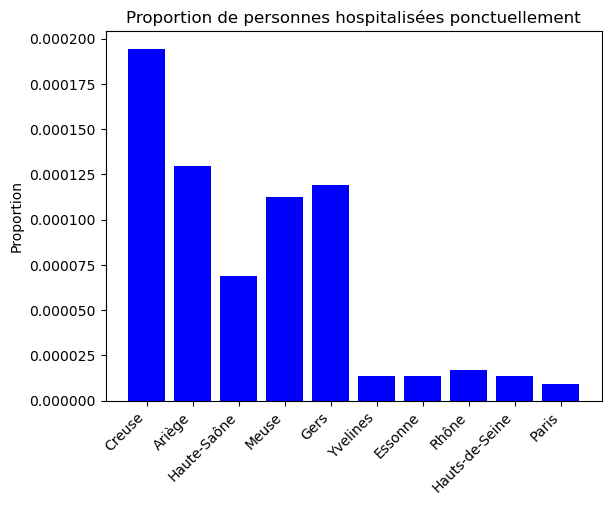

In [40]:
#Fonction qui prend en argument la table, les départements et la maladie étudiée et qui retourne un diagramme
#sur le taux de la pathologie dans les départements concernés

def plot_proportion_hospitalized_by_dep(dataframe, departements, maladie):
    # Création de dictionnaires pour la suite
    hospitalized_data_by_dep = {}
    data_by_dep = {}
    population_by_dep = {}
    proportion_hospitalized_by_dep = {}

    # Boucle pour filtrer les données pour chaque département
    for dep in departements:
        data_by_dep[dep] = dataframe[dataframe['nom_dep'] == dep]

    # Boucle pour filtrer les données pour chaque département
    for dep in departements:
        dep_data = dataframe[dataframe['nom_dep'] == dep]
        hospitalized_data = dep_data[dep_data['patho_niv1'] == maladie]
        hospitalized_data_by_dep[dep] = hospitalized_data

    # Boucle pour obtenir le nombre d'habitants pour chaque département
    for dep in departements:
        population_by_dep[dep] = dataframe.loc[dataframe['nom_dep'] == dep, 'total_habitants'].iloc[0]

    # Boucle pour calculer les proportions pour chaque département
    for dep in departements:
        # Filtrer les données hospitalisées pour le département actuel
        hospitalized_data = data_by_dep[dep][data_by_dep[dep]['patho_niv1'] == maladie]
        # Calculer la proportion de personnes hospitalisées
        proportion_hospitalized = len(hospitalized_data) / population_by_dep[dep]

        # Stocker la proportion dans le dictionnaire
        proportion_hospitalized_by_dep[dep] = proportion_hospitalized

    # Créer une liste pour stocker les tailles des barres
    sizes = []

    # Boucle pour récupérer les proportions spécifiques à chaque département
    for dep in departements:
        sizes.append(proportion_hospitalized_by_dep[dep])

    # Créer un diagramme en barres
    fig, ax = plt.subplots()
    ax.bar(departements, sizes, color=['blue'])
    ax.set_ylabel('Proportion')
    ax.set_title('Proportion de personnes hospitalisées ponctuellement')
    ax.set_xticks(ax.get_xticks())
    ax.set_xticklabels(departements, rotation=45, ha='right')

    plt.show()


# Utilisation

# Liste des départements que l'on garde
departements = ['Creuse', 'Ariège', 'Haute-Saône', 'Meuse', 'Gers', 'Yvelines', 'Essonne', 'Rhône', 'Hauts-de-Seine', 'Paris']
plot_proportion_hospitalized_by_dep(pop_eff_pol, departements, 'Hospitalisations ponctuelles (avec ou sans pathologies, traitements ou maternité)')

## CONCLUSION DE CETTE ETUDES DE CAS :


On observe une corrélation entre la richesse des habitants d’un département et la proportion de sa population qui est hospitalisée. Mais à ce stade nous ne pouvons pas conclure grand-chose quant à la causalité de la richesse des habitants sur leur niveau de santé. En effet, les habitants des départements les plus pauvres sont aussi plus âges en moyenne que ceux du Rhône et de la région parisienne.



La partie 2 explore ainsi le poids des variables disponibles dans la prédiction de la qualité de la santé des habitants des départements.
